In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [6]:
class ECHRDataset(Dataset):
        def __init__(self, data, attention_mask, labels):
            self.data = data
            self.attention_mask = attention_mask
            self.labels = labels

        def __len__(self):
            return len(self.data)

        def __getitem__(self, idx):
            return self.data[idx], self.attention_mask[idx], self.labels[idx]

In [15]:
path_to_datasets = 'embeddings_datasets/legal-bert-base-uncased/'
path_to_model = 'models/attention-mlp/'
create_dataset = False

if create_dataset:
        
    # pad the data to be of the same shape
    def pad_data(data, max_len):
        padded_data = []
        attention_masks = []
        for i in range(len(data)):
            attention_masks.append([1] * data[i].shape[0] + [0] * (max_len - data[i].shape[0]))
            padded_data.append(F.pad(data[i], (0, 0, 0, max_len - data[i].shape[0])))
        print(len(attention_masks))
        return torch.stack(padded_data), torch.tensor(attention_masks)

    # load data
    train = torch.load('embeddings/legal-bert-base-uncased/emb_tr_cpu.pkl')
    test = torch.load('embeddings/legal-bert-base-uncased/emb_test_cpu.pkl')
    dev = torch.load('embeddings/legal-bert-base-uncased/emb_dev_cpu.pkl')

    # load labels
    train_labels = pd.read_pickle('embeddings/legal-bert-base-uncased/train_labels.pkl')
    test_labels = pd.read_pickle('embeddings/legal-bert-base-uncased/test_labels.pkl')
    dev_labels = pd.read_pickle('embeddings/legal-bert-base-uncased/dev_labels.pkl')

    # pad the data
    max_len_train = max([x.shape[0] for x in train])
    max_len_test = max([x.shape[0] for x in test])
    max_len_dev = max([x.shape[0] for x in dev])
    train, train_attention_masks = pad_data(train, max_len_train)
    test, test_attention_masks = pad_data(test, max_len_test)
    dev, dev_attention_masks = pad_data(dev, max_len_dev)

    # create the datasets
    train_dataset = ECHRDataset(train, train_attention_masks, train_labels)
    test_dataset = ECHRDataset(test, test_attention_masks, test_labels)
    dev_dataset = ECHRDataset(dev, dev_attention_masks, dev_labels)

    print ("Dataset is on: "+train_dataset.data.device)

    # save the datasets
    if not os.path.exists(path_to_datasets):
        os.makedirs(path_to_datasets)
    torch.save(train_dataset, path_to_datasets+'train_dataset.pt')
    torch.save(test_dataset, path_to_datasets+'test_dataset.pt')
    torch.save(dev_dataset, path_to_datasets+'dev_dataset.pt')


In [52]:
if not create_dataset:
    train_dataset = torch.load(path_to_datasets+'train_dataset.pt')
    dev_dataset = torch.load(path_to_datasets+'dev_dataset.pt')
    test_dataset = torch.load(path_to_datasets+'test_dataset.pt')

In [ ]:
# TODO: Merge and shuffle train and dev dataset in a unique development dataset

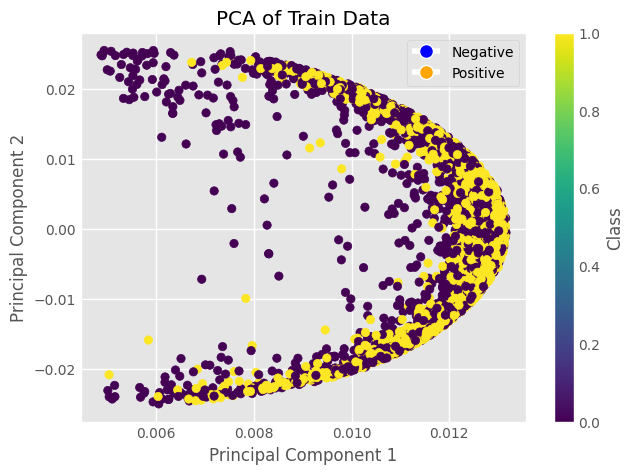

In [69]:
# PCA 

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
mean_train = np.array([x.mean(0).numpy() for x in train_dataset.data])
train_scaled = scaler.fit_transform(mean_train.T)

pca = PCA(n_components=2)
pca.fit(train_scaled)

# Plot the PCA components
plt.scatter(pca.components_[0], pca.components_[1], c=train_dataset.labels, cmap='viridis')

# Adding legend for positive and negative classes
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Negative'),
                    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='Positive')],
           loc='upper right')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Train Data')
plt.colorbar(label='Class')
plt.show()


In [70]:
# BASELINE on avg of chunks

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Assuming you have already defined and scaled mean_train and train_dataset.labels

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(mean_train, train_dataset.labels, test_size=0.2, random_state=42)

# Initializing the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Training the classifier
rf_classifier.fit(X_train, y_train)

# Predicting on the test set
y_pred = rf_classifier.predict(X_test)

# Calculating accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.7633802816901408


In [8]:
class AttentionMLP(nn.Module):
    def __init__(self, input_dim, hidden_sizes, dropout=0, weight_decay=0.01):
        super(AttentionMLP, self).__init__()
        # vector for query attention
        self.selector = nn.parameter.Parameter(torch.randn(input_dim, 1))
        self.Value= nn.Linear(input_dim, input_dim, bias=False)
        self.Key = nn.Linear(input_dim, input_dim, bias=False)
        # mlp layers
        layers = []
        for i in range(len(hidden_sizes) - 1):
            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i + 1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
        self.mlp = nn.Sequential(*layers)
        self.output = nn.Linear(hidden_sizes[-1], 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, attention_mask=None):
        # attention
        key = self.Key(x)

        value = self.Value(x)

        non_normalized_attention = torch.matmul(key, self.selector)
        if attention_mask is not None:
            attention_mask=attention_mask.unsqueeze(2)

            non_normalized_attention = non_normalized_attention.masked_fill(attention_mask == 0, -1e9)
        attention = F.softmax(non_normalized_attention, dim=1)
        # permute the attention to match the shape of the value
        attention = attention.permute(0, 2, 1)

        x = torch.matmul(attention, value)

        # mlp
        x = self.mlp(x)
        x = self.output(x)
        x = self.sigmoid(x)
        return x.squeeze()


In [73]:
# to device 
# check if windows or macos
if (torch.cuda.is_available()):
    print("Running on GPU")
    device = torch.device('cuda')
elif (torch.backends.mps.is_available()):
    print("Running on MPS")
    device = torch.device('mps')
else :
    print("Running on CPU")
    device = torch.device('cpu')

train_dataset.data = train_dataset.data.to(device)
train_dataset.labels = train_dataset.labels.to(device)
train_dataset.attention_mask = train_dataset.attention_mask.to(device)

dev_dataset.data = dev_dataset.data.to(device)
dev_dataset.labels = dev_dataset.labels.to(device)
dev_dataset.attention_mask = dev_dataset.attention_mask.to(device)


Running on MPS


In [10]:
# create the dataloader for the training set
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [77]:
# create the model
model = AttentionMLP(768, [768, 256, 64])
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001)
criterion = nn.BCELoss()

In [75]:
import torch
import os
from tqdm import tqdm

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
best_val_loss = float('inf')
best_model = None
epochs = 50

# TODO: K-Fold Cross Validation

# Initialize tqdm progress bar for epochs
epoch_progress_bar = tqdm(range(epochs), desc="Epochs", unit="epoch")

for epoch in epoch_progress_bar:
    running_loss = 0.0
    loop = tqdm(enumerate(train_dataloader), total=len(train_dataloader), leave=False)
    
    for i, data in loop:
        inputs, att_masks, labels = data

        optimizer.zero_grad()
        outputs = model(inputs, att_masks)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_dataloader)
    train_losses.append(train_loss)
    
    # Calculate training accuracy
    correct_predictions = (outputs > 0.5).eq(labels).sum().item()
    train_accuracy = correct_predictions / len(labels)
    train_accuracies.append(train_accuracy)

    # Validate the model
    with torch.no_grad():
        outputs = model(dev_dataset.data, dev_dataset.attention_mask)
        val_loss = criterion(outputs, dev_dataset.labels.float())
        val_losses.append(val_loss.item())
        
        # Calculate validation accuracy
        correct_predictions = (outputs > 0.5).eq(dev_dataset.labels).sum().item()
        val_accuracy = correct_predictions / len(dev_dataset.labels)
        val_accuracies.append(val_accuracy)

        # Save the model if it's the best so far for val loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()

    # Update the description of the epoch progress bar
    epoch_progress_bar.set_postfix({
        "Train Loss": train_loss,
        "Train Acc": train_accuracy,
        "Val Loss": val_loss.item(),
        "Val Acc": val_accuracy
    })

# save the best model for val loss 
if not os.path.exists(path_to_model):
    os.makedirs(path_to_model)
torch.save(best_model, f"{path_to_model}/{best_val_loss:.4f}.pt")

Epochs: 100%|██████████| 50/50 [01:54<00:00,  2.28s/epoch, Train Loss=0.309, Train Acc=0.917, Val Loss=0.342, Val Acc=0.856]


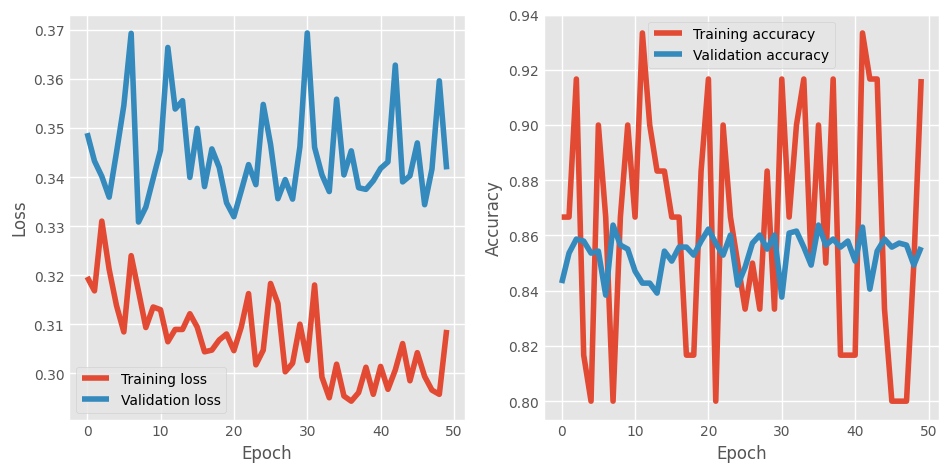

In [76]:
# print traianing and validation loss
plt.style.use('ggplot')

# plot two image by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(train_losses, label='Training loss')
ax[0].plot(val_losses, label='Validation loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(train_accuracies, label='Training accuracy')
ax[1].plot(val_accuracies, label='Validation accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
plt.show()

In [ ]:
# test the model
#with torch.no_grad():
#    outputs = model(test)
#    loss = criterion(outputs, test_labels.float())
#    print(f'Test loss: {loss.item()}')
#    from sklearn.metrics import classification_report
#    print(classification_report(test_labels.cpu().numpy(), (outputs > 0.5).cpu().numpy()))